### **How to think in JAX?**

```bash
pip install jax
```

or

```bash
pip install -U "jax[cuda12]"
```

In [1]:
import jax.numpy as jnp # jax can be used like numpy

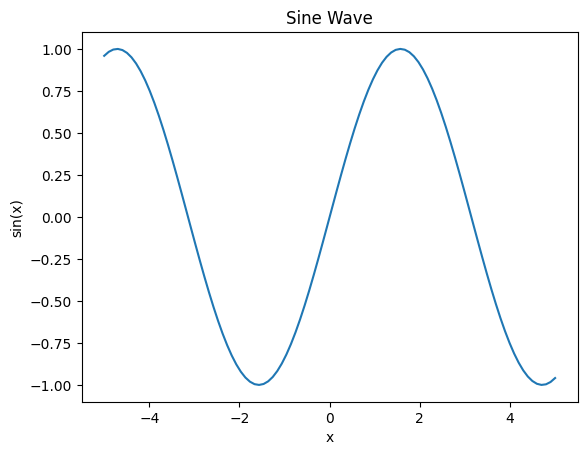

In [2]:
import matplotlib.pyplot as plt

x_jnp = jnp.linspace(-5, 5, 100)
y_jnp = jnp.sin(x_jnp)

plt.plot(x_jnp, y_jnp)
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()

The code blocks are identical to `NumPy`. As we can see JAX arrays can be often be used directly in place of NumPy

In [3]:
type(x_jnp)

jaxlib._jax.ArrayImpl

Python's duck-typing allows JAX arrays and NumPy arrays to be used interchangebly, but there's on difference , JAX arrays are immutable, meaning that once created their contents cannot be changed.

In [4]:
import numpy as np

x = np.arange(10)
x[0] = 10  # numpy's mutable arrays
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [5]:
x = jnp.arange(10)
x[0] = 10  # jax's immutable arrays, this will give an error
print(x)

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

For updating individual elements, JAX provides an "indexed update syntax" that returns an updated copy:

In [6]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## **JAX arrays** (`jax.Array`)

It create arrays using JAX API functions, JAX array objects have a `devices` attribute that indicates where the array is stored.

JAX arrays can be sharded across multiple devices for parallel computation

#### **Array creation**

We don't directly call the `jax.Array` constructor directly, but rather create arrays via JAX API functions

In [7]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
isinstance(x, jax.Array)

True

#### Array devices and sharding


JAX array objects have a `device` method that lets you inspect where the contents of array are stored.

In [8]:
x.devices()

{CudaDevice(id=0)}

It's on the GPU.

In general, an array may be sharded across multiple devices, in a manner that can be inspected via the `sharding` attribute:

In [9]:
x.sharding

SingleDeviceSharding(device=CudaDevice(id=0), memory_kind=device)

Here the array in on a single device, but in general a JAX array can be sharded across multiple devices, or even multiple hosts.

We will leanr more about it in [Distributed arrays and automatic parallelization](#insert-link-here) and [Introduction to parallel programming](#intro-to-parallel-prog)

## **Just-in-time compilation with `jax.jit`**

By default JAX executes operations one at a time, in sequence. Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once.

Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time


JAX runs transparenlty on the GPU or TPU( falling back to CPU, if you don't have one), with all JAX operations being expressed in terms of XLA. 




In [10]:
import jax.numpy as jnp

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

A just in time compiled version of the function can be created using the `jax.jit` transform

In [11]:
from jax import jit

norm_compiled = jit(norm)
    

This function returns the same results as the origina, up to a standard floating-point accuracy:

In [15]:
np.random.seed(135)
X = jnp.array(np.random.rand(10000,1000))
np.allclose(norm(X), norm_compiled(X))

True

But due to the compilation, which includes fusing of operations, avoidance of allocating temporary arrays, and a host of other tricks, execution times can be orders of magnitude faster in the JIT-compiled case. We can use IPython's `%timeit` to quickly benchmark our function, using `block_until_ready()` to account for JAX's [asynchronous dispatch](https://github.com/MonitSharma/parallel_adventures/blob/main/Research/JAX/tutorial_async.ipynb)

In [17]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

2 ms ± 61.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.49 ms ± 90.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`jax.jit` does have limitations: in particular, it requires all arrays to have static shapes. That means that some JAX operation are incompatible with JIT compilation.

In [18]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

Array([-1.3874749], dtype=float32)

But we will see an error if it is compiled in `jit` because it's not  static, since we don't know before what the size of array will be, the size of output depends on the values of the input array, so it is not compatible with jit

In [20]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[10]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

See more of it in [Just-in-time compilation](https://github.com/MonitSharma/parallel_adventures/blob/main/Research/JAX/tutorial_1.ipynb)

#### **JIT Mechanics: tracing and static variables**

JIT and JAX transforms work by tracing a function to determine its effect on inputs of a specific shape and type. Variables that you don't want to be traced can be marked as static.

To use `jax.jit` effectively, it is useful to understand how it works. Let's put a few `print()` statements within a JIT-compiled function and then call the function:


In [21]:
@jit 
def f(x,y):
    print("running f():")
    print(f"  {x=  }")
    print(f"  {y=  }")
    result = jnp.dot(x+1,y+1)
    print(f"  {result=  }")
    return result

x = np.random.randn(3,4)
y = np.random.randn(4)
f(x,y)

running f():
  x=  JitTracer<float32[3,4]>
  y=  JitTracer<float32[4]>
  result=  JitTracer<float32[3]>


Array([6.674986 , 8.154674 , 2.5762057], dtype=float32)

In [22]:
print(x)
print(y)

[[ 0.37476029 -0.2341051   0.41204127  0.64999969]
 [ 0.86820025  0.70792005  0.79355349 -0.4552949 ]
 [ 0.16310156 -0.13070938 -0.39515918 -2.40605737]]
[ 0.3203004  -0.17257388  1.1694592  -0.29527154]


As you can see, the print statements execute, but instead of printing the data we passed to the function, it prints tracer objects that stand-in for them.


These tracer objects are what `jax.jit` uses to extract the sequence of operations specified by the function. Basic tracers are stand-ins that encode the shape and dtype of the arrays, but are agnostic to the values. This recorded sequence of computations can then be efficiently applied within XLA to new inputs with the same shape and dtype, without having to re-execute the Python code.


When we call the compiled function again on matching inputs, no re-compilation is required and nothing is printed because the result is computed in compiled XLA rather than in Python

In [23]:
x2 = np.random.randn(3,4)
y2 = np.random.randn(4)

f(x2,y2)

Array([2.3937492, 1.6446352, 1.4824106], dtype=float32)

The extracted sequence of operations is encoded in a JAX expression, or `jaxpr` for short. We can see the jaxpr using `jax.make_jaxpr` transformation:

In [24]:
from jax import make_jaxpr

def f(x,y):
    return jnp.dot(x+1,y+1)

print(make_jaxpr(f)(x,y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0:f32[]
    d:f32[4] = add b 1.0:f32[]
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


Now, since JIT compilation is done without information on the content of the array, control flow statements in the function cannot depend on traced values. For example, this fails:

In [25]:
@jit 
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /tmp/ipykernel_62311/2143173482.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

If there are variables that you would not like to be traced, they can be marked as static for the purpose of JIT compilation:

In [26]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    return -x if neg else x

f(1,True)

Array(-1, dtype=int32, weak_type=True)

In [27]:
f(1,False)

Array(1, dtype=int32, weak_type=True)

Understanding whcih values and operations will be static and which will be traced is a key part of using `jax.jit` effectively.

### **Taking derivatives with `jax.grad`**

JAX provides automatic differentiation via the `jax.grad` transformation. The `jax.grad` and `jax.jit` transformation compose can be mixed arbitrarily.

In addition to transforming functions via JIT compilation, JAX also provides other transformations. One such transformation is `jax.grad()`, which performs [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) or see this [page](https://huggingface.co/blog/andmholm/what-is-automatic-differentiation)

In [29]:
from jax import grad

def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661194 0.10499357]


In [33]:
print(x_small)

[0. 1. 2.]


In [34]:
type(x_small)

jaxlib._jax.ArrayImpl

Let's verify it with finite difference:

In [30]:
def first_finite_differences(f, x, eps=1E-3):
    return jnp.array([(f(x + eps *v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


The `grad()` and `jit()` transformation compose and can be mixed arbitrarily. 

In [32]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


Beyond scalar-valued functions, the `jax.jacobian()` transformation can be used to compute the full Jacobian matrix for vector-valued functions:

In [35]:
from jax import jacobian
print(jacobian(jnp.exp)(x_small))

[[1.        0.        0.       ]
 [0.        2.7182817 0.       ]
 [0.        0.        7.389056 ]]


For more advanced autodiff operations, you can use `jax.vjp()` for reverse mode vector Jacobian products, and `jax.jvp()` and `jax.linearize()` for forward-mode Jacobian vector products. The two can be composed arbitrarily with one another, and with other JAX transformations. 

For example, `jax.jvp()` and `jax.vjp()` are used to define the forward-mode `jax.jacfwd()` and reverse mode `jax.jacrev()` for computing Jacobians in forward- and reverse-mode, respectively. Here's one way to compose them to make a function that efficiently computes full Hessian matrices:

In [39]:
from jax import jacfwd, jacrev

def hessian(fun):
    return jit(jacfwd(jacrev(fun)))

print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085774 -0.        ]
 [-0.         -0.         -0.07996248]]


This kind of composition produces efficient code in practice; this is more-or-less how JAX's built-in `jax.hessian()` function is implemented.

see more of it in [automatic differentiation](#automatic-diff)

### **Auto-vectorization with `jax.vmap()`**

JAX provides automatic vectorization via the `jax.vmap` transformation.
`jax.vmap` can be composed with `jax.jit` to produce efficient vectorized code.

Another useful transformation is `vmap()`, the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of explicitly looping over function calls, it transforms the function into a natively vectorized version for better performance. 

When composed with `jit()` it can be just as performant as manually rewriting your function to operate over extra batch dimension

Say you have a function that multiplies a matrix by a vector:

In [40]:
def matvec(A,x):
    return jnp.dot(A,x)


This works on one vector `x` . But what if you have a batch of vectors (a matrix `X`) and want all `Ax` products

Without `vmap` (manual loop)

In [41]:
def batched_matvec(A,X):
    return jnp.stack([matvec(A,x) for x in X])

this uses a python loop, slow and not JAX optimized

With `vmap`

In [42]:
batched_matvec = jax.vmap(matvec, in_axes=(None, 0))



`in_axes=(None,0)` means:
    - `A` is the same for all calls 
    - `X` is batched along axis `0`

In [43]:
A = jnp.ones((3,3))
X = jnp.ones((5,3))
print(batched_matvec(A,X).shape)

(5, 3)


Suppose you write a function `f(x)` that works on a single input:

In [46]:
def f(x):
    return jnp.sin(x) + x**2

Now, you don;t just have one input, you have a batch of inputs

In [47]:
xs = jnp.arange(5.0)

**Naive Python Way:**

In [49]:
results = [f(x) for x in xs]

print(results)

[Array(0., dtype=float32), Array(1.841471, dtype=float32), Array(4.9092975, dtype=float32), Array(9.14112, dtype=float32), Array(15.243197, dtype=float32)]


Loops in python, produces the right result, but inefficiently.


**NumPy/JAX broadcasting way:**

In [50]:
results = f(xs)

print(results)



[ 0.         1.841471   4.9092975  9.14112   15.243197 ]


Because `jnp.sin` and `**2` are already vectorized

But here's the catch:

Not all functions are written to handle batches, for example if `f` takes matrices, structured inputs, or outputs, rewriting `f` to batches can be messy.


That's where `vmap` comes in:

It takes your function that works on a single input, automatically lift it to work on a batch of inputs, efficiently

In [51]:
import jax

f_batched = jax.vmap(f)

results = f_batched(xs)


In [52]:
print(results)

[ 0.         1.841471   4.9092975  9.14112   15.243197 ]


```python
jax.vmap(fun, in_axes=0, out_axes=0)
```

- `fun` - function that works on a single example
- `in_axes` - tells JAX which arguments to map over
    - `0` = map over axis 0
    - `None` = don't map over this arguments
- `out_axes` - tells JAX where to put the batch axis in output

In [44]:
from jax import random

key = random.key(135)
key1, key2 = random.split(key)

mat = random.normal(key1, (150,100))

batched_x = random.normal(key2, (10, 100))


def apply_matrix(x):
    return jnp.dot(mat,x)

The `apply_matrix` function maps a vector to a vector, but we may want to apply it row-wise across a matrix. We could do this by looping over the batch dimension in Python, but this usually results in poor performance

In [57]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
1.47 ms ± 162 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A programmer familiar with `jnp.dot` function might recognise that `apply_matrix` can be rewritten to avoid explicit looping, using the built-in batching semantics of `jnp.dot`:

In [59]:
import numpy as np
import jax.numpy as jnp
from jax import jit

# Define test data
mat = np.random.randn(5, 5)
batched_x = np.random.randn(10, 5)

# Naive implementation
def naively_batched_apply_matrix(batched_x):
    return np.dot(batched_x, mat.T)

# JAX implementation
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, mat.T)

# Test they're close
np.testing.assert_allclose(
    naively_batched_apply_matrix(batched_x), 
    batched_apply_matrix(batched_x), 
    atol=1E-4, rtol=1E-4
)

print("Manually Batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually Batched
331 μs ± 13.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


However, as functions become more complicated, this kind of manual batching becomes more difficult and error-prone. The `vmap()` transformation is designed to automatically transform a function into a batch-aware version:

In [60]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
301 μs ± 13.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`vmap()` can be arbitrarily composed with `jit()` , `grad()` and any other JAX transformation.


See more on [Automatic vectorization](#automatic-vector)

### **Pseudorandom numbers**

JAX uses a different model for pseudo random number generation than NumPy, JAX random functions consume a random `key` that must be split to generate new independent keys.

JAX's random key model is thread-safe and avoids issues with global state. 


Generally, JAX strives to be compatible with NumPy, but pseudo random number generation is notable exception. NumPy supports a method of pseudo random number generation that is based on a global `state`, which can be set using `numpy.random.seed`. Global random state interacts poorly with JAX's compute model and makes it difficult to enforce reproducibility across different threads, processes, and devices. JAX instead tracks state explicitly via a random `key`:

In [61]:
from jax import random

key = random.key(43)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 43]


The key is effectively a stand-in for NumPy’s hidden state object, but we pass it explicitly to jax.random functions. Importantly, random functions consume the key, but do not modify it: feeding the same key object to a random function will always result in the same sample being generated.

In [62]:
print(random.normal(key))
print(random.normal(key))

0.07520543
0.07520543


The rule of thumb is: never reuse keys (unless you want identical outputs).

In order to generate different and independent samples, you must jax.random.split the key explicitly before passing it to a random function:

In [63]:
for i in range(3):
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: -1.9133632183074951
draw 1: -1.4749839305877686
draw 2: -0.36703771352767944


Note that this code is thread safe, since the local random state eliminates possible race conditions involving global state. jax.random.split is a deterministic function that converts one key into several independent (in the pseudorandomness sense) keys.

For more on pseudo random numbers in JAX, see the [Pseudorandom numbers tutorial](#pseudorandom-numbers).